In [7]:
import iris
from scipy.spatial import KDTree
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import iris.coord_categorisation
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import pandas as pd
import datetime
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde


In [8]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)

def extract_lat_lon(cube,my_lat,my_lon):
    lat = cube.coord('latitude')
    lon = cube.coord('longitude')
    lat_coord1 = lat.nearest_neighbour_index(my_lat)
    lon_coord1 = lon.nearest_neighbour_index(my_lon)
    return cube.data[:,lat_coord1,lon_coord1].data

In [9]:
file = '/Users/ph290/Downloads/era5_GBR/era5_GBR_surfacetemperature.nc'
file_bottom = '/Users/ph290/Downloads/era5_GBR/era5_GBR_bottomtemperature.nc'

# cube = iris.load_cube(file)[0]

cube_all_bottom = iris.load_cube(file_bottom)
cube_all = iris.load_cube(file)
try:
    iris.coord_categorisation.add_year(cube_all, 'time', name='year')
    iris.coord_categorisation.add_month(cube_all, 'time', name='month')
except:
    pass

try:
    iris.coord_categorisation.add_year(cube_all_bottom, 'time', name='year')
    iris.coord_categorisation.add_month(cube_all_bottom, 'time', name='month')
except:
    pass

# cube_all = cube_all.aggregated_by('year', iris.analysis.MEAN)


# cube_all.coord('longitude').points = cube_all.coord('longitude').points+180
# cube_all.data = np.ma.masked_array(cube_all.data)
# cube_all.data.fill_value = 9.96920997e+36
cube_all.data = np.ma.masked_where(cube_all.data == 9.96920997e+36, cube_all.data)
cube_all_bottom.data = np.ma.masked_where(cube_all_bottom.data == 9.96920997e+36, cube_all_bottom.data)

a = cube_all[0,:,:].data.copy()
a = np.ma.masked_where(np.logical_not(np.isfinite(a)),a)
x,y=np.meshgrid(cube_all.coord('longitude').points,cube_all.coord('latitude').points)
xygood = np.array((x[~a.mask],y[~a.mask])).T


In [52]:
#https://portal.aodn.org.au/search

# obs_file = 'NRSNSI.csv.gz'
# obs_file = 'GBRLSH.csv.gz'
# obs_file = 'GBRPPS.csv.gz'
# obs_file = 'NRSYON.csv.gz'
# obs_file = 'GBRHIS.csv.gz'
# df = pd.read_csv('data/'+obs_file, compression='gzip',header=21)


obs_file = 'IMOS_FAIMMS.csv.gz'
df = pd.read_csv('data/'+obs_file, compression='gzip',header=39)



SyntaxError: invalid syntax (<ipython-input-52-f2135c7ba4e9>, line 13)

In [55]:
df2 = df.loc[df.NOMINAL_DEPTH < 2.0]


In [56]:
site_codes = np.unique(df2.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
site_code = site_codes[24]
df_surf = df2.loc[(df2.site_code == site_code) & (df.VALUES_quality_control == 1)]
lat = df_surf.LATITUDE.mean()
lon = df_surf.LONGITUDE.mean()

In [57]:


min_lon = np.min(cube_all.coord('longitude').points)
max_lon = np.max(cube_all.coord('longitude').points)
min_lat = np.min(cube_all.coord('latitude').points)
max_lat = np.max(cube_all.coord('latitude').points)

# if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
#     fig= plt.subplots(figsize=(10, 10))
#     #plot map of the mooring location
#     qplt.pcolormesh(cube_all[0])
#     plt.scatter(lon,lat)
#     plt.show()



In [61]:
obs_values=np.array([])
obs_latitude=np.array([])
obs_month=np.array([])
model_values=np.array([])


site_codes = np.unique(df2.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
for site_code in site_codes:
    df_surf = df2.loc[(df.site_code == site_code) & (df2.VALUES_quality_control == 1)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()

#     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            try:
        #         df_surf['old_TIME'] = df_surf.TIME
                df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
                df_surf = df_surf.set_index('TIME_datetime',drop=False)
            except:
                pass
            df_surf['month'] = df_surf.TIME_datetime.dt.month
            df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()

            basedate = pd.Timestamp('1970-01-01')

            model_dates = times[where_good_data]
            model_days_since_bas = ( pd.to_datetime(model_dates)- basedate).days.values
            model_data = model_ts[where_good_data]
            
            obs_days_since_bas = (df_surf.index- basedate).days.values
#             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))
#             obs_days_since_bas = obs_days_since_bas[finite_obs_data_loc]
            loc_where_obs_days_within_model_days =  np.where((obs_days_since_bas <= np.max(model_days_since_bas)) & (np.isfinite(df_surf.VALUES.values)) & (df_surf.VALUES.values >17.0 ))[0]
            obs_days_since_bas = obs_days_since_bas[loc_where_obs_days_within_model_days]
#             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))

            interp_function = interp1d(model_days_since_bas, model_data)

            # plt.scatter(obs_days_since_bas,df_surf.VALUES.values[finite_obs_data_loc],color='r',alpha=0.5)
#             plt.scatter(obs_days_since_bas, interp_function(obs_days_since_bas), color='b',alpha=0.1)
            obs_values = np.append(obs_values, df_surf.VALUES.values[loc_where_obs_days_within_model_days])
            model_values = np.append(model_values, interp_function(obs_days_since_bas))
            obs_latitude = np.append(obs_latitude,df_surf.LATITUDE.values[loc_where_obs_days_within_model_days])
            obs_month = np.append(obs_month,df_surf.month.values[loc_where_obs_days_within_model_days])
#             plt.scatter(df_surf.VALUES.values[loc_where_obs_days_within_model_days],interp_function(obs_days_since_bas))

    #     if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
    #         plt.plot(times[where_good_data],model_ts[where_good_data])
    #         try:
    #     #         df_surf['old_TIME'] = df_surf.TIME
    #             df_surf['TIME_datetime'] = pd.to_datetime(df_surf.TIME,format='%Y-%m-%dT%H:%M:%SZ')
    #             df_surf['year'] = df_surf.TIME_datetime.dt.year
    #             df_surf['month'] = df_surf.TIME_datetime.dt.month
    #             df_surf['day'] = df_surf.TIME_datetime.dt.day
    #             df_surf = df_surf.set_index('TIME_datetime',drop=False)
    #         except:
    #             pass

    #         df_surf = df_surf.groupby(pd.Grouper(freq='1D')).mean()
    #         plt.scatter(df_surf.index.values,df_surf.VALUES.values,color='r')
    #         plt.show()



/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


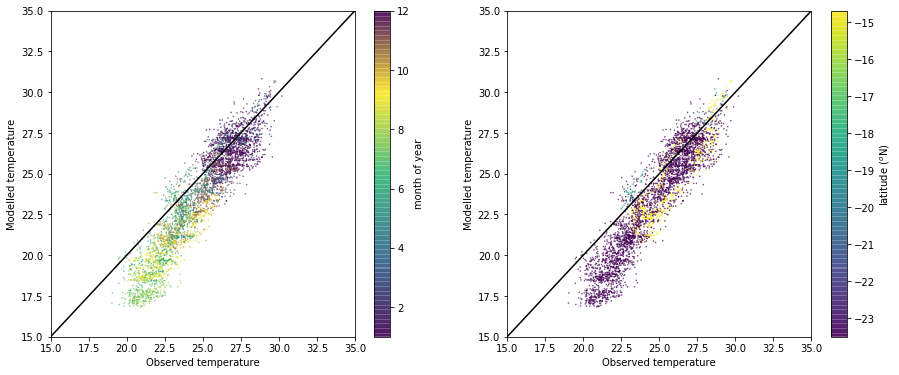

In [62]:
import matplotlib.cm
import matplotlib.colors

cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

x,y=obs_values,model_values
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month, s=2.5, edgecolor='',alpha=0.7, cmap=cyclic_viridis)
ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed temperature')
ax1.set_ylabel('Modelled temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude, s=2.5, edgecolor='',alpha=0.7, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed temperature')
ax2.set_ylabel('Modelled temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validation_IMOS_FAIMMS.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_FAIMMS.png')

plt.show()

# Bottom temperatures

In [23]:

# obs_file = 'NRSNSI.csv.gz' # 63m
# obs_file = 'GBRLSH.csv.gz' # 31m
# obs_file = 'GBRPPS.csv.gz' # 68m
# obs_file = 'NRSYON.csv.gz' # 27m
# obs_file = 'GBRHIS.csv.gz' # 43m
# obs_file = 'GBROTE.csv.gz' #59.3m
# df_bottom = pd.read_csv('data/'+obs_file, compression='gzip',header=21)


In [24]:
sites = ['NRSNSI','GBRLSH','NRSYON','GBRHIS']
depths =[63,31,27,43]

In [25]:


obs_values_bottom=np.array([])
obs_latitude_bottom=np.array([])
obs_month_bottom=np.array([])
model_values_bottom=np.array([])

for i,dummy in enumerate(sites):
    df_bottom = pd.read_csv('data/'+sites[i]+'.csv.gz', compression='gzip',header=21)

    df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-5.0]

    try:
        lat = df_bottom_tmp.LATITUDE.mean()
    except:
        lat = df_bottom_tmp.LATITUDE.iloc[0]

    try:
        lon = df_bottom_tmp.LONGITUDE.mean()
    except:
        lon = df_bottom_tmp.LONGITUDE.iloc[0]
        
    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all_bottom,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            try:
        #         df_surf['old_TIME'] = df_surf.TIME
                df_bottom_tmp['TIME_datetime'] = pd.to_datetime(df_bottom_tmp.TIME,format='%Y-%m-%dT%H:%M:%SZ')
                df_bottom_tmp = df_bottom_tmp.set_index('TIME_datetime',drop=False)
            except:
                pass
            df_bottom_tmp['month'] = df_bottom_tmp.TIME_datetime.dt.month
            df_bottom_tmp = df_bottom_tmp.groupby(pd.Grouper(freq='1D')).mean()

            basedate = pd.Timestamp('1970-01-01')

            model_dates = times[where_good_data]
            model_days_since_bas = ( pd.to_datetime(model_dates)- basedate).days.values
            model_data = model_ts[where_good_data]

            obs_days_since_bas = (df_bottom_tmp.index- basedate).days.values
    #             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))
    #             obs_days_since_bas = obs_days_since_bas[finite_obs_data_loc]
            loc_where_obs_days_within_model_days =  np.where((obs_days_since_bas <= np.max(model_days_since_bas)) & (np.isfinite(df_bottom_tmp.TEMP.values)))[0]
            obs_days_since_bas = obs_days_since_bas[loc_where_obs_days_within_model_days]
    #             finite_obs_data_loc = np.where(np.isfinite(df_surf.VALUES.values))

            interp_function = interp1d(model_days_since_bas, model_data)

            # plt.scatter(obs_days_since_bas,df_surf.VALUES.values[finite_obs_data_loc],color='r',alpha=0.5)
    #             plt.scatter(obs_days_since_bas, interp_function(obs_days_since_bas), color='b',alpha=0.1)
            obs_values_bottom = np.append(obs_values_bottom, df_bottom_tmp.TEMP.values[loc_where_obs_days_within_model_days])
            model_values_bottom = np.append(model_values_bottom, interp_function(obs_days_since_bas))
            obs_latitude_bottom = np.append(obs_latitude_bottom,df_bottom_tmp.LATITUDE.values[loc_where_obs_days_within_model_days])
            obs_month_bottom = np.append(obs_month_bottom,df_bottom_tmp.month.values[loc_where_obs_days_within_model_days])

/Users/ph290/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ph290/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


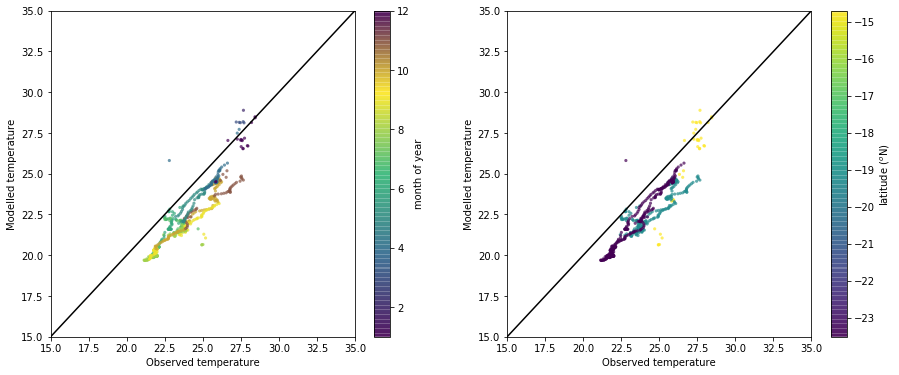

In [27]:
import matplotlib.cm
import matplotlib.colors

cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

x,y=obs_values_bottom,model_values_bottom
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude_bottom, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month_bottom, s=10, edgecolor='',alpha=0.7, cmap=cyclic_viridis)
ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed temperature')
ax1.set_ylabel('Modelled temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude_bottom, s=10, edgecolor='',alpha=0.7, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed temperature')
ax2.set_ylabel('Modelled temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_bottom_t_validation_IMOS_FAIMMS.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_bottom_t_validationIMOS_FAIMMS.png')

plt.show()

### Surface and bottom together

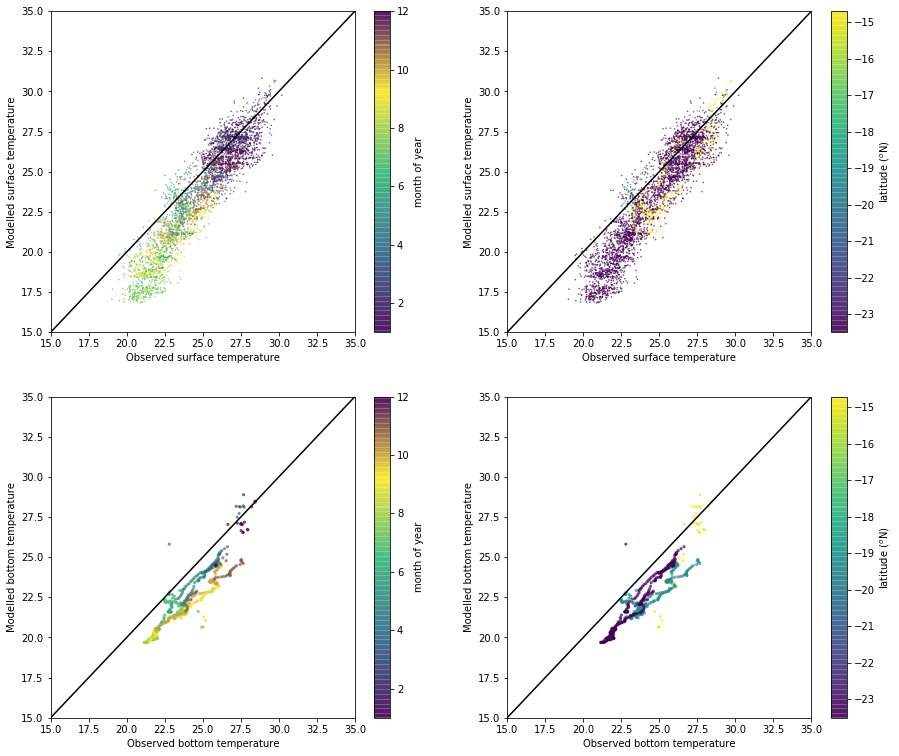

In [64]:
import matplotlib.cm
import matplotlib.colors

cyclic_viridis = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, matplotlib.cm.viridis.colors[0]),
     (0.25, matplotlib.cm.viridis.colors[256 // 3]),
     (0.5, matplotlib.cm.viridis.colors[2 * 256 // 3]),
     (0.75, matplotlib.cm.viridis.colors[-1]),
     (1.0, matplotlib.cm.viridis.colors[0])])

### surface

x,y=obs_values,model_values
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,13))
# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax1.scatter(x, y, c=obs_month, s=2.5, edgecolor='',alpha=0.7, cmap=cyclic_viridis)
ax1.set_ylim([15,35])
ax1.set_xlim([15,35])
ax1.set_xlabel('Observed surface temperature')
ax1.set_ylabel('Modelled surface temperature')
ax1.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax1)
cbar1.set_label('month of year')


c2 = ax2.scatter(x, y, c=obs_latitude, s=2.5, edgecolor='',alpha=0.7, cmap=cm.viridis)
ax2.set_ylim([15,35])
ax2.set_xlim([15,35])
ax2.set_xlabel('Observed surface temperature')
ax2.set_ylabel('Modelled surface temperature')
ax2.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax2)
cbar2.set_label('latitude ($^o$N)')


### bottom

x,y=obs_values_bottom,model_values_bottom
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# ax.scatter(x, y, c=z, s=10, edgecolor='', cmap=cm.plasma)
# c = ax.scatter(x, y, c=obs_latitude_bottom, s=20, edgecolor='',alpha=0.25, cmap=cm.viridis)
c = ax3.scatter(x, y, c=obs_month_bottom, s=10, edgecolor='',alpha=0.7, cmap=cyclic_viridis)
ax3.set_ylim([15,35])
ax3.set_xlim([15,35])
ax3.set_xlabel('Observed bottom temperature')
ax3.set_ylabel('Modelled bottom temperature')
ax3.plot([0,40],[0,40],'k')
cbar1 = plt.colorbar(c,ax=ax3)
cbar1.set_label('month of year')


c2 = ax4.scatter(x, y, c=obs_latitude_bottom, s=10, edgecolor='',alpha=0.7, cmap=cm.viridis)
ax4.set_ylim([15,35])
ax4.set_xlim([15,35])
ax4.set_xlabel('Observed bottom temperature')
ax4.set_ylabel('Modelled bottom temperature')
ax4.plot([0,40],[0,40],'k')
cbar2 = plt.colorbar(c2,ax=ax4)
cbar2.set_label('latitude ($^o$N)')

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


# plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validation_IMOS_surf_and_bottom.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_surf_and_bottom.png')

plt.show()

In [ ]:
projection=ccrs.PlateCarree()
ax3 = plt.axes([0, 0, 1, 1], projection=projection)
ax3.set_extent([135, 160, -40, -5], ccrs.PlateCarree())
ax3.coastlines('50m')


for i,dummy in enumerate(sites):
    df_bottom = pd.read_csv('data/'+sites[i]+'.csv.gz', compression='gzip',header=21)
    df_bottom_tmp = df_bottom.loc[df_bottom.DEPTH > depths[i]-5.0]

    try:
        lat = df_bottom_tmp.LATITUDE.mean()
    except:
        lat = df_bottom_tmp.LATITUDE.iloc[0]

    try:
        lon = df_bottom_tmp.LONGITUDE.mean()
    except:
        lon = df_bottom_tmp.LONGITUDE.iloc[0]
        
    #     fig= plt.subplots(figsize=(10, 10))

    if np.isfinite(KDTree(xygood).query([lon,lat])[0]):
        index = KDTree(xygood).query([lon,lat])[1]
    #     xygood[index][0]
        model_ts = extract_lat_lon(cube_all_bottom,xygood[index][1],xygood[index][0])
        time = cube_all.coord('time')
        times = time.units.num2date(time.points)
        where_good_data = np.where(model_ts < 1000.0)

        if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
            if i== 0:
                ax3.scatter(lon,lat,color='b',s=200,alpha=0.3,label='surface observations')
            else:
                ax3.scatter(lon,lat,color='b',s=200,alpha=0.3,label='surface observations')


site_codes = np.unique(df.site_code)
# 7,8,12,13,14,16,17,18,21,22,23,24
for i,site_code in enumerate(site_codes):
    df_surf = df.loc[(df.site_code == site_code) & (df.VALUES_quality_control == 1)]
    # note a a QC flag pv  2 will define that the ARGO quality control procedure was used for the dataset. QC of 1 hade some spruriously low values
    lat = df_surf.LATITUDE.mean()
    lon = df_surf.LONGITUDE.mean()
    if (lon >= min_lon) & (lon <= max_lon) & (lat >= min_lat) & (lat <= max_lat):
        if i == 0:
            ax3.scatter(lon,lat,color='r',s=50,alpha=0.5,label='surface observations')
        else:
            ax3.scatter(lon,lat,color='r',s=50,alpha=0.5)
            
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/GBR_sst_validationIMOS_bottom_sites.png')
